In [294]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv


### **overview **

In [295]:
# importing library
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.utils import resample
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import classification_report

In [296]:
df=pd.read_csv("/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")

In [297]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [298]:
df["Message"]

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [299]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

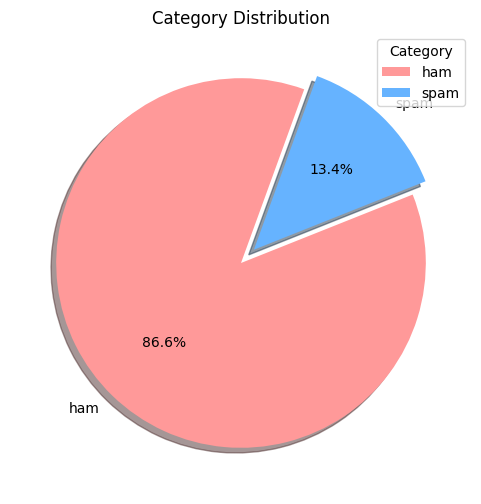

In [300]:
plt.figure(figsize=(6,6))
colors = ['#ff9999', '#66b3ff']
explode = (0, 0.1)
plt.pie(x=df['Category'].value_counts().values, labels=['ham', 'spam'], 
        autopct='%.1f%%', startangle=70, explode=explode, colors=colors, shadow=True)
plt.legend(title="Category", loc="upper right")
plt.title("Category Distribution")
plt.show()

**unbalancing data**

In [301]:
ham_msg = df[df.Category == "ham"]
spam_msg = df[df.Category == 'spam']

**balancing data**

In [302]:
ham_downsample = resample(ham_msg,
             replace=True,
             n_samples=len(spam_msg),
             random_state=42)

In [303]:
data = pd.concat([ham_downsample, spam_msg])

In [304]:
data

,Category,Message
1014,ham,Just buy a pizza. Meat lovers or supreme. U ge...
4364,ham,Evry Emotion dsn't hav Words.Evry Wish dsn't h...
3570,ham,She's fine. Sends her greetings
546,ham,Then any special there?
5121,ham,"Oops I did have it, &lt;#&gt; ?"
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [305]:
data["Category"].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

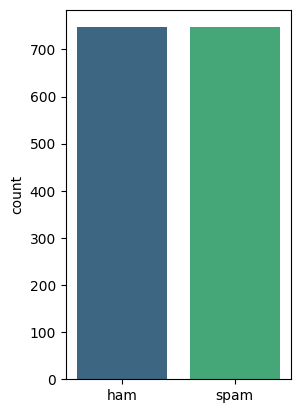

In [306]:
plt.subplot(1, 2, 2)
sns.barplot(x = data['Category'].unique(), y = data['Category'].value_counts(), palette= 'viridis')

plt.show()

**preprocessing text**

In [307]:
data

,Category,Message
1014,ham,Just buy a pizza. Meat lovers or supreme. U ge...
4364,ham,Evry Emotion dsn't hav Words.Evry Wish dsn't h...
3570,ham,She's fine. Sends her greetings
546,ham,Then any special there?
5121,ham,"Oops I did have it, &lt;#&gt; ?"
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


# **preprossing**

**lowercase**

In [308]:
print(data["Message"].iloc[2])
def convert_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(convert_lowercase)

data["Message"].iloc[2]

**removing punctuation**

In [310]:
# print(data["Message"].iloc[6])
# punctuations_list = string.punctuation
# def remove_punctuations(text):
#     temp = str.maketrans('', '', punctuations_list)
#     return text.translate(temp)
 
# data['Message']= data['Message'].apply(lambda x: remove_punctuations(x))
# data["Message"].iloc[6]

**removing stopwords**

In [311]:
# print(data["Message"].iloc[12])
# def remove_stopwords(text):
#     stop_words = stopwords.words('english')
 
#     imp_words = []
 
#     # Storing the important words
#     for word in str(text).split():
#         word = word.lower()
 
#         if word not in stop_words:
#             imp_words.append(word)
 
#     output = " ".join(imp_words)
 
#     return output
 
 
# data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))
# data["Message"].iloc[12]

**removing digits**

In [312]:
# print(data["Message"].iloc[-5])
# data['Message'] = data['Message'].apply(lambda x:re.sub('[\d]','',x))
# data["Message"].iloc[-5]

**Stemming**

In [1]:
# print(data["Message"].iloc[2])
# def perform_stemming(text):
#     stemmer = PorterStemmer()
#     new_list = []
#     words = word_tokenize(text)
#     for word in words:
#         new_list.append(stemmer.stem(word))

#     return " ".join(new_list)

# data['Message'] = data['Message'].apply(perform_stemming)
# data["Message"].iloc[2]

# EDA

**** visualize frequent words in spam email****

In [314]:
all_spam_words = []
for sentence in data[data['Category'] == "spam"]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
df = pd.DataFrame(Counter(all_spam_words).most_common(50), columns= ['Word', 'Frequency'])
df.style.background_gradient(cmap='Purples')

,Word,Frequency
0,to,604
1,a,360
2,your,187
3,or,185
4,call,183
5,the,175
6,2,169
7,for,169
8,you,164
9,is,142


In [315]:
fig = px.treemap(df, path=['Word'], values='Frequency', title='Tree of Most Common Words', color='Frequency')
fig.show()

In [316]:
fig = px.bar(
    df, 
    x="Frequency", 
    y="Word", 
    title='Common Words in SPAM', 
    width=700, 
    height=700,
    color='Frequency',  # Set the color based on the count of common words
    color_continuous_scale='YlGnBu',  # Specify a color scale 
)
fig.update_layout(
    xaxis_title="Frequency",
    yaxis_title=None,  # Remove the y-axis title
    title_font=dict(size=40),  # Increase title font size
    font=dict(size=20),  # Increase general text font size
)


fig.update_xaxes(showgrid=False)  # Hide x-axis grid lines
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')  # Show and style y-axis grid lines

fig.show()

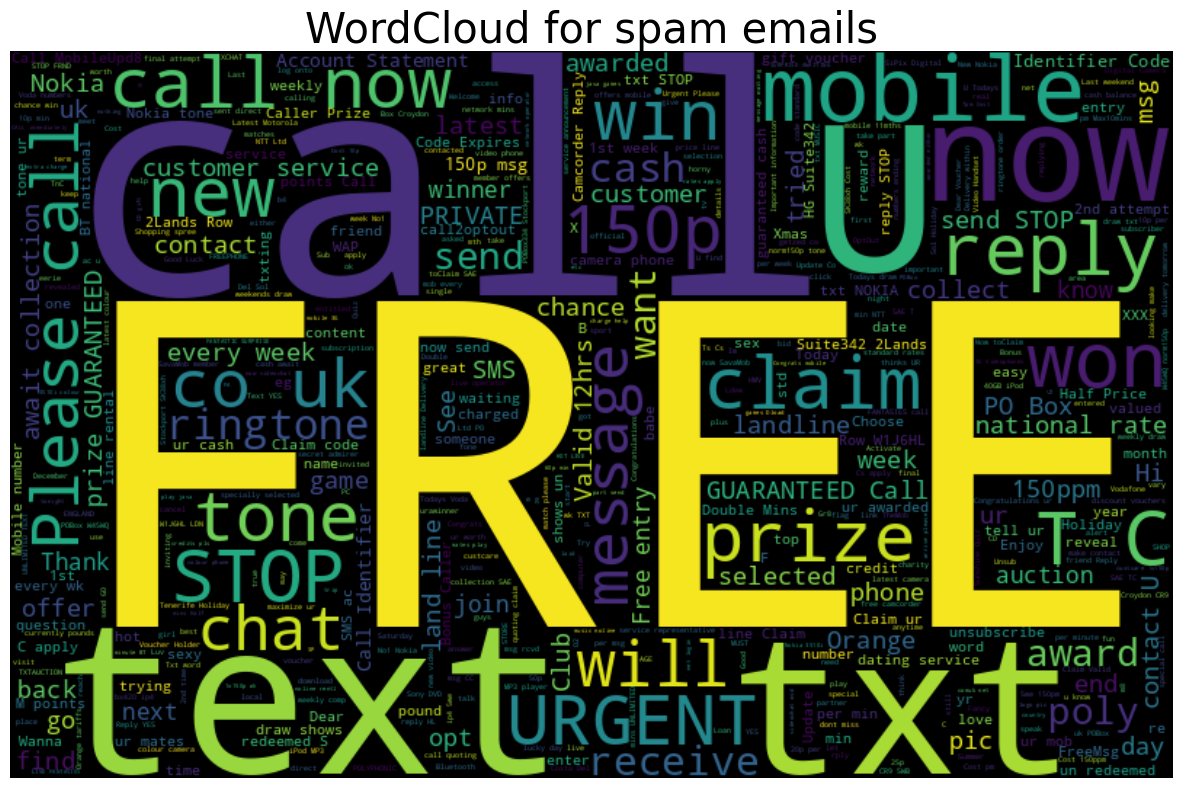

In [317]:
text = " ".join(data[data['Category'] == 'spam']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 500, width = 800,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('WordCloud for spam emails', fontsize=30)
plt.axis('off')
plt.show()

**** visualize frequent words in ham email****

In [318]:
all_spam_words = []
for sentence in data[data['Category'] == "ham"]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
df = pd.DataFrame(Counter(all_spam_words).most_common(50), columns= ['Word', 'Frequency'])
df.style.background_gradient(cmap='Blues')

,Word,Frequency
0,you,237
1,to,230
2,I,214
3,the,171
4,a,159
5,and,120
6,in,111
7,is,108
8,me,106
9,u,103


In [319]:
fig = px.treemap(df, path=['Word'], values='Frequency', title='Tree of Most Common Words', color='Word')
fig.show()

In [320]:
fig = px.bar(
    df, 
    x="Frequency", 
    y="Word", 
    title='Most Common Negative Words', 
    width=700, 
    height=700,
    color='Frequency',  # Set the color based on the count of common words
    color_continuous_scale='YlOrRd',  # Choose the 'YlGnBu' color scale
)

fig.show()

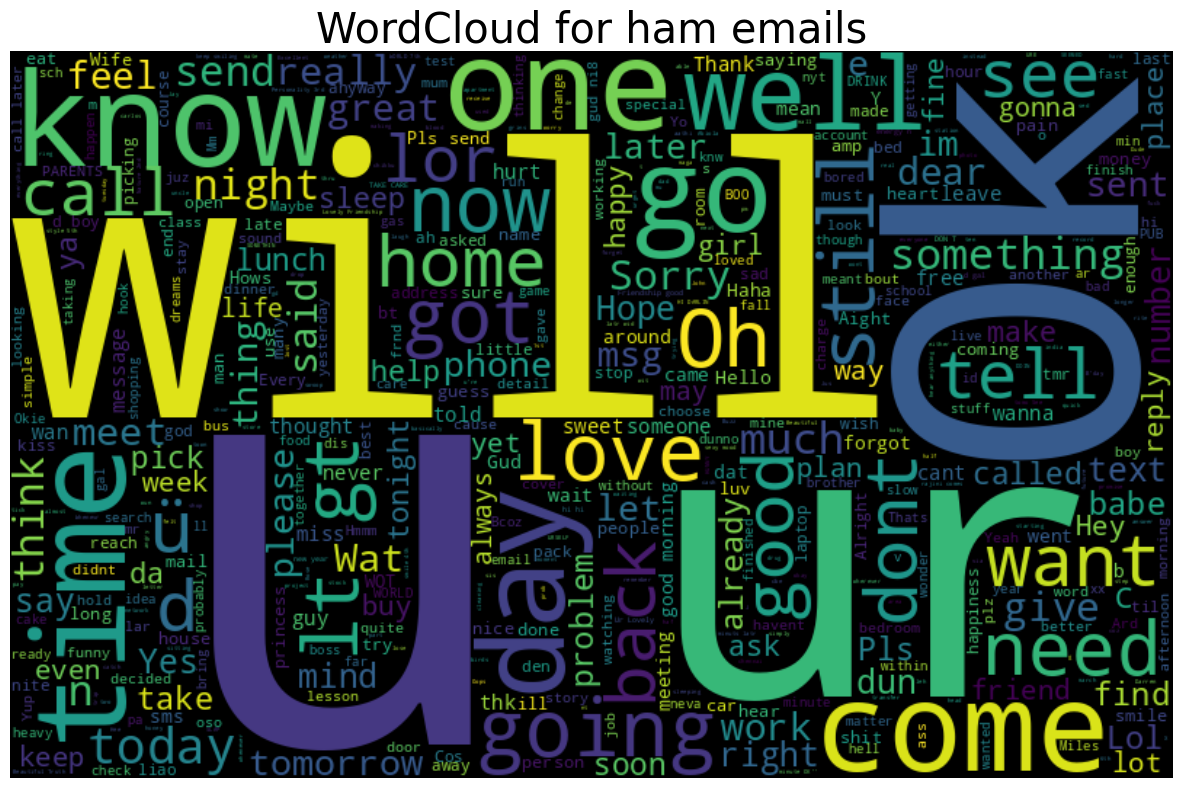

In [321]:
text = " ".join(data[data['Category'] == 'ham']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 500, width = 800,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('WordCloud for ham emails', fontsize=30)
plt.axis('off')
plt.show()

# modeling**

**encoding**

In [322]:

labelencoder = preprocessing.LabelEncoder()
data['Category'] = labelencoder.fit_transform(data['Category'])
Y = data['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1494,)


In [323]:
X = data["Message"]

In [324]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state= 42)

In [325]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1045,)
(449,)
(1045,)
(449,)


**vectorizing**

In [326]:
tfidf = TfidfVectorizer(max_features= 3000)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

**MultinomialNB**

In [327]:
NB = MultinomialNB()
NB.fit(X_train, Y_train)

# Calculate the score on the training set
train_score = NB.score(X_train, Y_train)
print("Training Score:", train_score)

# Calculate the score on the test set
test_score = NB.score(X_test, Y_test)
print("Test Score:", test_score)

Training Score: 0.9837320574162679
Test Score: 0.9621380846325167


In [328]:
Y_predict = NB.predict(X_test)
print("F1 = " , f1_score(Y_test, Y_predict))

F1 =  0.9632829373650108


In [329]:
print(classification_report(Y_test, Y_predict, target_names = ['Ham','Spam']))

              precision    recall  f1-score   support

         Ham       0.96      0.96      0.96       217
        Spam       0.97      0.96      0.96       232

    accuracy                           0.96       449
   macro avg       0.96      0.96      0.96       449
weighted avg       0.96      0.96      0.96       449



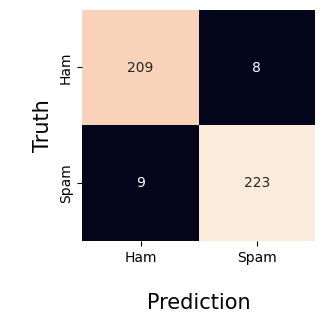

In [330]:
cm = confusion_matrix(Y_test,Y_predict)
classes = ['Ham','Spam']

plt.figure(figsize = (3,3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar=False).set(xticklabels = classes, yticklabels = classes)
plt.xlabel("\nPrediction", size = 15)
plt.ylabel("\nTruth",  size = 15)
plt.show()

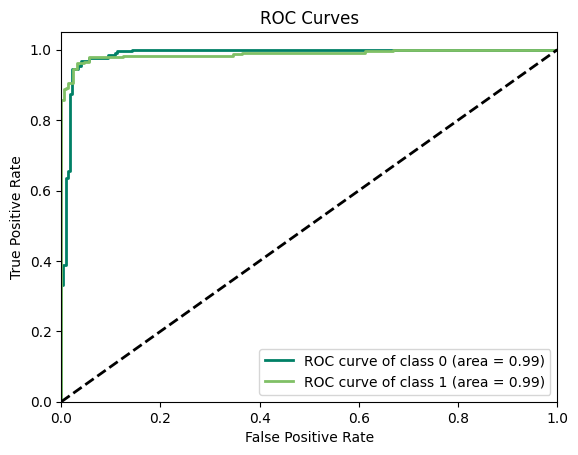

In [331]:
Y_prob = NB.predict_proba(X_test)
ax2 = plot_roc(Y_test,  Y_prob ,  plot_macro= False, plot_micro= False, cmap= 'summer')

**Randomforest**

In [332]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
# Calculate the score on the training set
train_score = NB.score(X_train, Y_train)
print("Training Score:", train_score)

# Calculate the score on the test set
test_score = NB.score(X_test, Y_test)
print("Test Score:", test_score)

Training Score: 0.9837320574162679
Test Score: 0.9621380846325167


In [333]:
print(classification_report(Y_test, Y_predict, target_names = ['Ham','Spam']))

              precision    recall  f1-score   support

         Ham       0.96      0.96      0.96       217
        Spam       0.97      0.96      0.96       232

    accuracy                           0.96       449
   macro avg       0.96      0.96      0.96       449
weighted avg       0.96      0.96      0.96       449



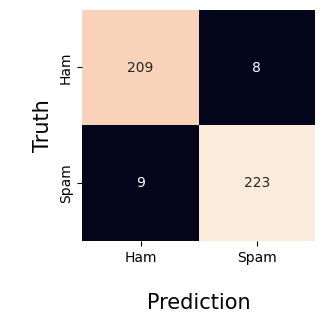

In [334]:
cm = confusion_matrix(Y_test,Y_predict)
classes = ['Ham','Spam']

plt.figure(figsize = (3,3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar=False).set(xticklabels = classes, yticklabels = classes)
plt.xlabel("\nPrediction", size = 15)
plt.ylabel("\nTruth",  size = 15)
plt.show()

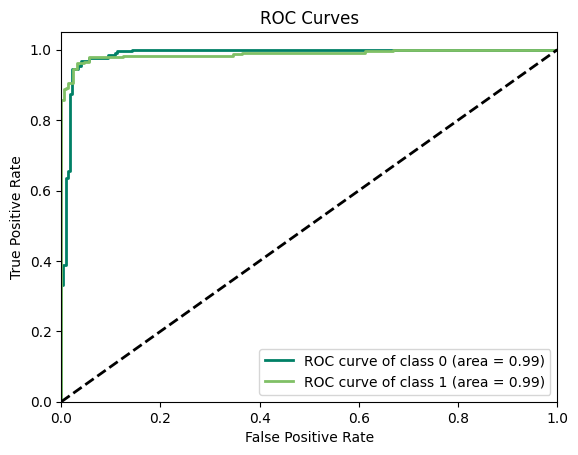

In [335]:
Y_prob = NB.predict_proba(X_test)
ax2 = plot_roc(Y_test,  Y_prob ,  plot_macro= False, plot_micro= False, cmap= 'summer')